In [9]:
### Display
from IPython.core.display import display, HTML

### Widgets
#import ipywidgets as widgets

### Data Handline
import pandas as pd
import numpy as np

### Utility
import math
import string
import datetime
import pickle

### Plotting
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "Arial"
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
# Matplotlib toolkits
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Seaborn
import seaborn as sns
# Plotly
import plotly.graph_objects as go
# Gespatial data with cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 
# ### Frequent Pattern Mining
# from mlxtend.frequent_patterns import apriori
# from mlxtend.frequent_patterns import fpgrowth
# from mlxtend.frequent_patterns import association_rules as arule
# 
# ### Text Mining
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer
# from nltk.lm.preprocessing import padded_everygram_pipeline
# from nltk.lm import MLE
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

### PM4Py
import pm4py
# Log Handling
from pm4py.objects.conversion.log import converter as log_converter
# Statistics
from pm4py.statistics.traces.generic.log import case_statistics
# Filtering
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.attributes import attributes_filter
# Discovery and Conformance Checking
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.objects.conversion.process_tree import converter as pt_converter
# Visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer


import os
from scipy.stats import gaussian_kde


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14396\148901242.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [10]:
import copy


def get_dataframe_from_log_data(data):
    return pd.DataFrame(
        data,
        columns=[
        "proc_tree_input",
        "proc_tree_post_repair",
        "tree_updated",
        "sampled_variants_positive",
        "sampled_variant_negative",
        "approach_used",
        "applied_rules",
        "positive_variants_conformance_post_repair",
        "resulting_tree_edit_distance",
        "failed_updates",
        "update_operations"
        ],
    )



def get_experiment_output_log(filename: str):
    data2 = []
    infile = open(filename, "rb")
    while 1:
        try:
            data2.append(pickle.load(infile))
        except (EOFError, pickle.UnpicklingError):
            break
    infile.close()

    return data2



def draw_baseline_comparison_line_charts(data_negative_process_model_repair, data_sub_tree_rating, data_heuristic_brute_force, data_complete_brute_force):
    
    line_colors = ['dodgerblue', 'green', 'darkorchid', 'red']
    line_styles = ['dashdot', 'dashed', 'dotted', (0, (3, 1, 1, 1, 1, 1))]
    alpha = 0.6
    
    data_negative_process_model_repair['index'] = data_negative_process_model_repair.index
    data_negative_process_model_repair['index'] += 1
    data_sub_tree_rating['index'] = data_sub_tree_rating.index
    data_sub_tree_rating['index'] += 1
    data_heuristic_brute_force['index'] = data_heuristic_brute_force.index
    data_heuristic_brute_force['index'] += 1
    data_complete_brute_force['index'] = data_complete_brute_force.index
    data_complete_brute_force['index'] += 1
    
    plt.clf()
    
    attributes = {
        'positive_variants_conformance_post_repair': 'Positive Variants Fitness',
        'resulting_tree_edit_distance': 'Edit Distance',
        'update_operations': 'Number of Update/Conformance Operations'
    }
    
    for key in attributes:
        plt.figure(figsize=(12, 7), dpi=100)
        
        (line_3,) = plt.plot(
            data_negative_process_model_repair['index'],
            data_negative_process_model_repair[key],
            linestyle=line_styles[0], marker='o', color=line_colors[0],
            alpha=alpha,
        )
        line_3.set_label("orchestrated negative repair")
        (line_1,) = plt.plot(
            data_sub_tree_rating['index'],
            data_sub_tree_rating[key],
            linestyle=line_styles[1], marker='o', color=line_colors[1],
            alpha=alpha,
        )
        line_1.set_label("sub-tree rating")
        (line_2,) = plt.plot(
            data_heuristic_brute_force['index'],
            data_heuristic_brute_force[key],
            linestyle=line_styles[2], marker='o', color=line_colors[2],
            alpha=alpha,
        )
        line_2.set_label("heuristic brute force")
        
        (line_4,) = plt.plot(
            data_complete_brute_force['index'],
            data_complete_brute_force[key],
            linestyle=line_styles[3], marker='o', color=line_colors[3],
            alpha=alpha,
        )
        line_4.set_label("complete brute force")
        
        plt.xlabel("Iteration")
        plt.ylabel(attributes[key])
        # plt.grid()
        plt.legend()
        plt.xticks(range(1,len(data_sub_tree_rating)+1))
        plt.title('')
        plt.show()

    return



def draw_box_plots_for_all_approaches(df_npmr, df_str, df_hbf,  df_cbf):
    attributes = {
        'positive_variants_conformance_post_repair': 'Positive Variants Fitness',
        'resulting_tree_edit_distance': 'Edit Distance',
        'update_operations': 'Number of Update/Conformance Operations'
    }
    
    for key in attributes:
        data = [
            df_npmr[key].values,
            df_str[key].values,
            df_hbf[key].values,
            df_cbf[key].values
        ]
        # Multiple box plots on one Axes
        fig, ax = plt.subplots()
        ax.boxplot(data)
        ax.set_xticklabels(['Orchestrated Negative Repair', 'Sub-tree Rating', 'Heuristic Brute Force', 'Complete Brute Force'],
                        rotation=0, fontsize=8)
        plt.ylabel(attributes[key])
        plt.show()



def add_update_rules_from_data_frame(df, update_rules):
    aa = 10
    for (index,), applied_rule in np.ndenumerate(df['applied_rules'].values):
        rule_name = copy.deepcopy(applied_rule)
        
        if len(rule_name.split(' ')) >= 3 and (rule_name.split(' ')[0] == 'loop:' or rule_name.split(' ')[0] == 'loop'):
            rule_name = copy.deepcopy(rule_name.split(' ')[0]) + ' ' + copy.deepcopy(rule_name.split(' ')[1])
            
        if rule_name not in update_rules:
            update_rules[rule_name] = [[], [], []] # [ fitness, edit-distance, update operations ]
        update_rules[rule_name][0].append(df['positive_variants_conformance_post_repair'].values[index])
        update_rules[rule_name][1].append(df['resulting_tree_edit_distance'].values[index])
        update_rules[rule_name][2].append(df['update_operations'].values[index])
    return update_rules

def draw_box_plots_for_update_rules(df_npmr, df_str, df_hbf,  df_cbf):
    update_rules = {} # dict(str: [fitness, edit_distance, operations])
    
    add_update_rules_from_data_frame(copy.deepcopy(df_npmr), update_rules)
    add_update_rules_from_data_frame(copy.deepcopy(df_str), update_rules)
    add_update_rules_from_data_frame(copy.deepcopy(df_hbf), update_rules)
    add_update_rules_from_data_frame(copy.deepcopy(df_cbf), update_rules)
    
    all_rules = list(update_rules.keys())
    all_rules.sort()
    attributes = {
        0: 'Positive Variants Fitness',
        1: 'Edit Distance',
        2: 'Number of Update/Conformance Operations'
    }
    
    for key in attributes:
        data = []
        for update_rule in all_rules:
            data.append(np.array(update_rules[update_rule][key]))
        
        # Multiple box plots on one Axes
        fig, ax = plt.subplots()
        ax.boxplot(data)
        ax.set_xticklabels(all_rules,
                        rotation=40, fontsize=8)
        plt.ylabel(attributes[key])
        plt.show()



from matplotlib.colors import Normalize 
def draw_scatter_plots_fitness_edit_distance(xdata, ydata, title):
    # Calculate the point density
    xy = np.vstack([xdata,ydata])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = xdata[idx], ydata[idx], z[idx]
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=140, edgecolors='k', cmap='Greens')
    plt.title(title)
    
    ax.set_xlabel('Edit Distance')
    ax.set_ylabel('Positive Variants Fitness')
    
    norm = Normalize(vmin = np.min(-z), vmax = np.max(-z))
    cbar = plt.colorbar(cm.ScalarMappable(norm = norm, cmap='Greens'), ax=ax)
    cbar.ax.set_ylabel('Density')
    cbar.ax.get_yaxis().set_ticks([])
      
    return



def draw_plots_for_all_approaches(dir_path, title):
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    print(title)
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    
    dir_list = os.listdir(dir_path)
    
    approach_names = ['complete_brute_force', 'heuristic_brute_force', 'sub_tree_rating', 'negative_process_model_repair']

    for approach_name in approach_names:
        experiments_log = []
        for dir in [k for k in dir_list if approach_name in k]:
            experiments_log.extend(get_experiment_output_log(dir_path + '\\' + dir))
            
        experiment_data = get_dataframe_from_log_data(experiments_log)
    
        if approach_name == 'complete_brute_force':
            approach_title = 'Complete Brute Force'
            df_cbf = experiment_data
        if approach_name == 'heuristic_brute_force':
            approach_title = 'Heuristic Brute Force'
            df_hbf = experiment_data
        elif approach_name == 'negative_process_model_repair':
            approach_title = 'Orchestrated Negative Repair'
            df_npmr = experiment_data
        elif approach_name == 'sub_tree_rating':
            approach_title = 'Sub-tree Rating'
            df_str = experiment_data
        
        draw_scatter_plots_fitness_edit_distance(
            experiment_data.resulting_tree_edit_distance.values,
            experiment_data.positive_variants_conformance_post_repair.values,
            approach_title
        )

    draw_box_plots_for_all_approaches(df_npmr, df_str, df_hbf,  df_cbf)
    draw_baseline_comparison_line_charts(
        df_npmr, 
        df_str, 
        df_hbf, 
        df_cbf
    )
    draw_box_plots_for_update_rules(df_npmr, df_str, df_hbf,  df_cbf)
    

-------------------------------------------------------------------------------------------------------------------------------------------------------
RequestForPayment: Shifting window sampling (10) / Varied negative variants / Thresholds: fitness(min): 85, edit-distance(max): 5, threshold stop: TRUE
-------------------------------------------------------------------------------------------------------------------------------------------------------


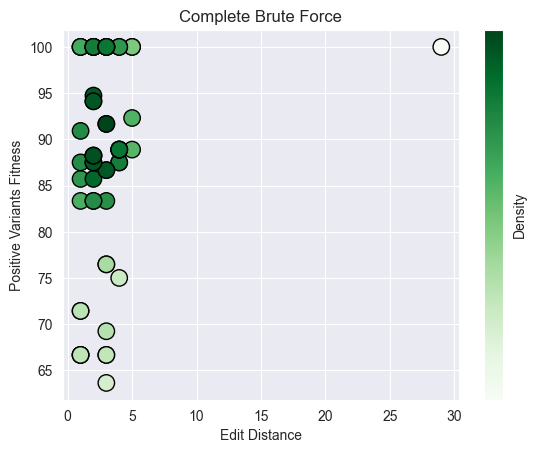

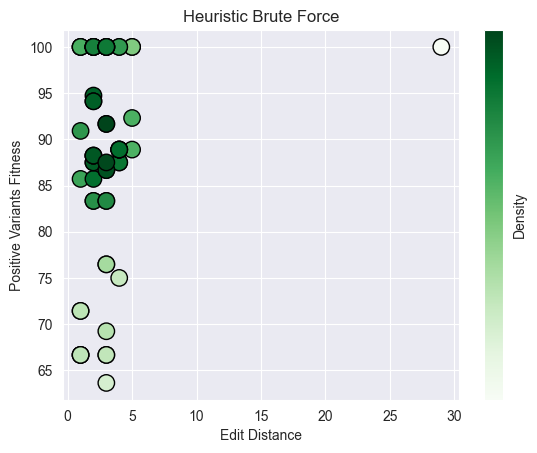

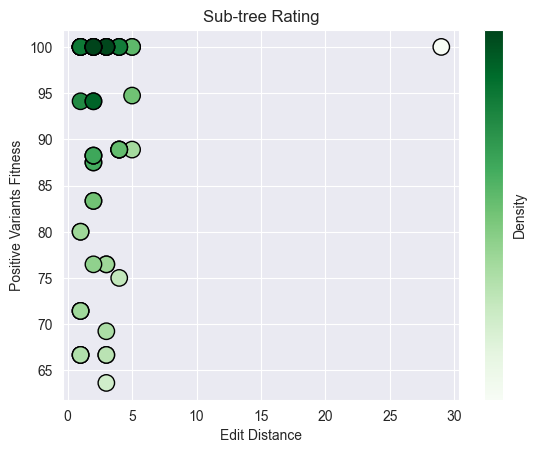

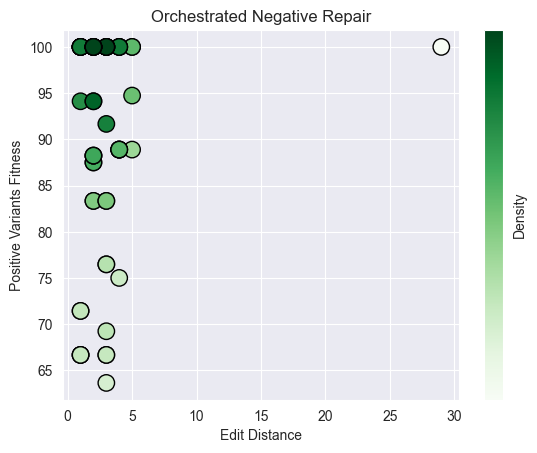

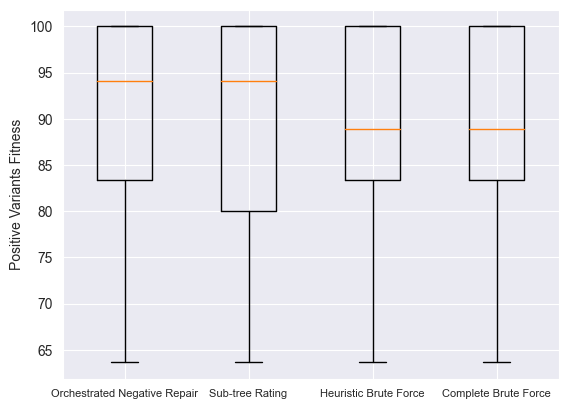

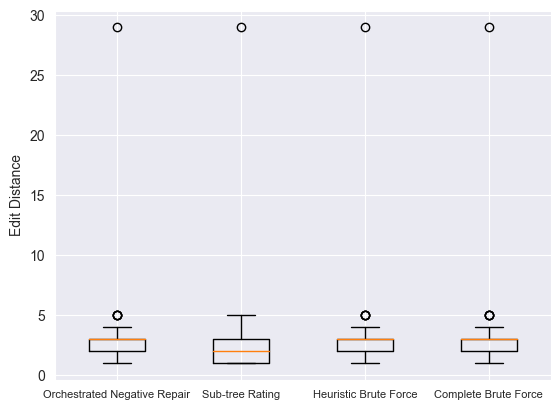

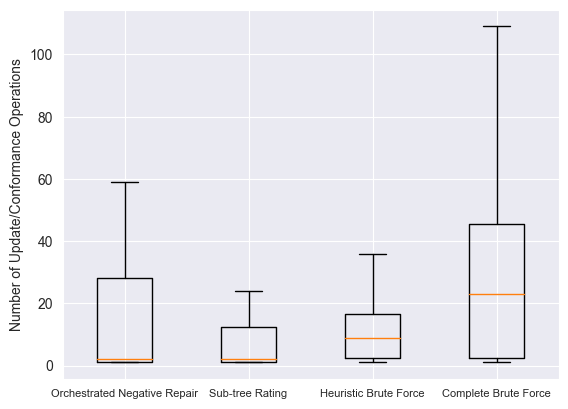

<Figure size 640x480 with 0 Axes>

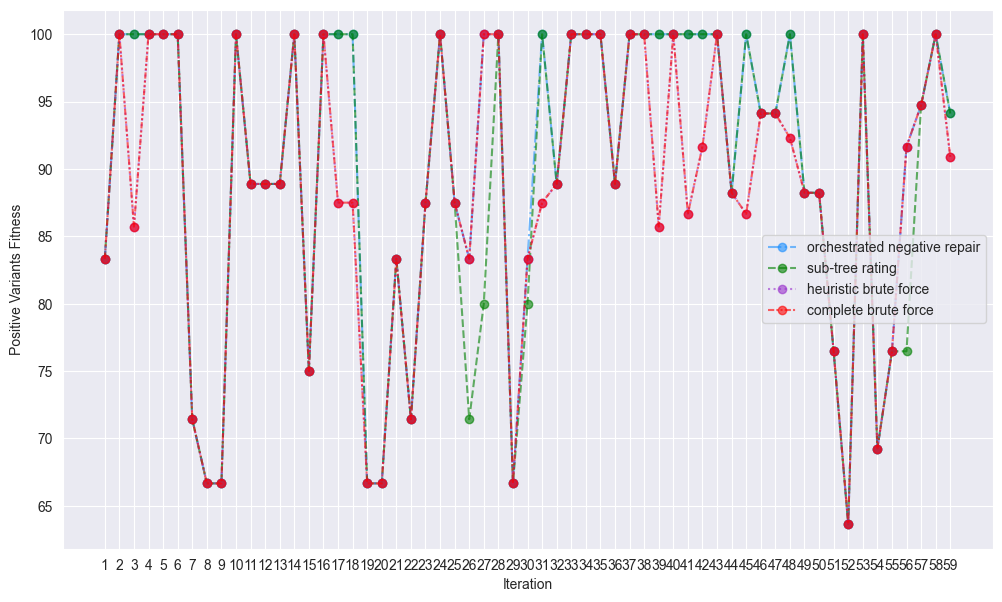

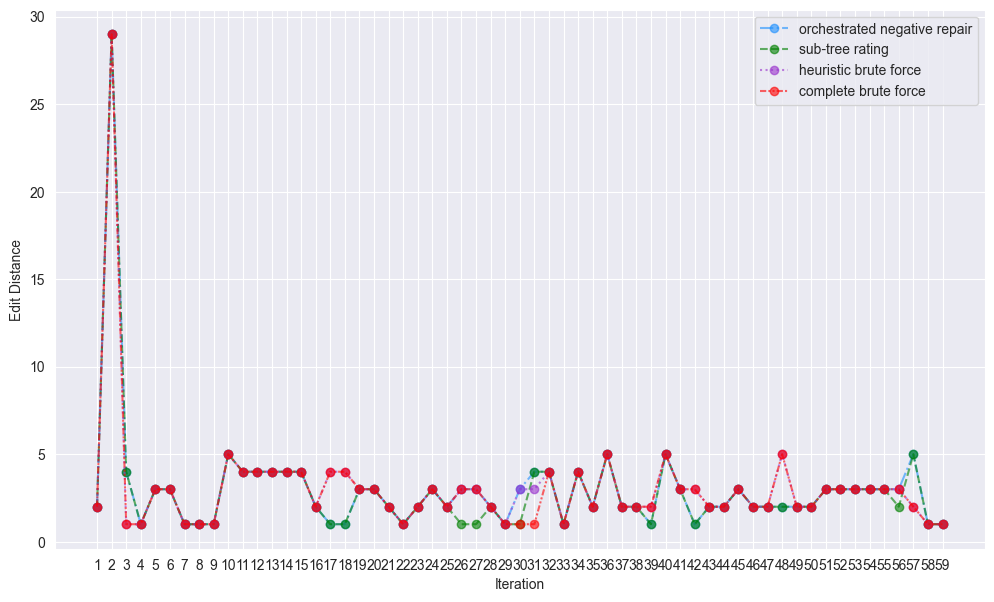

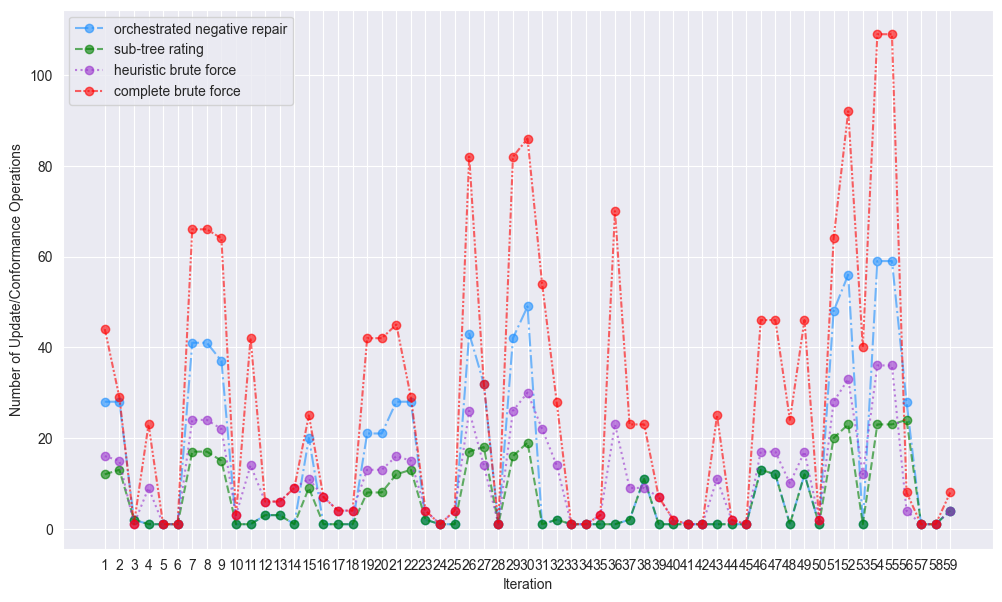

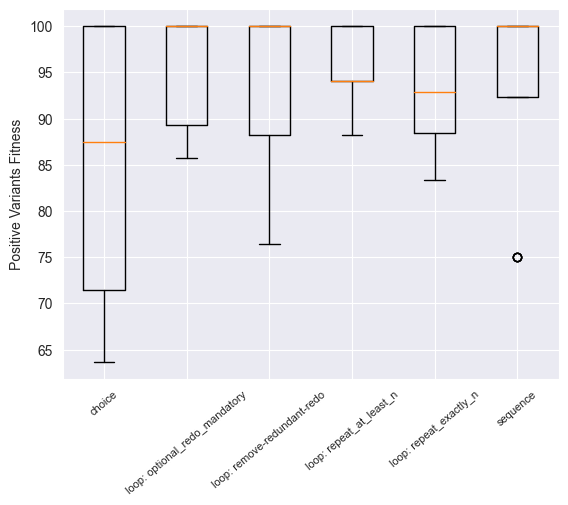

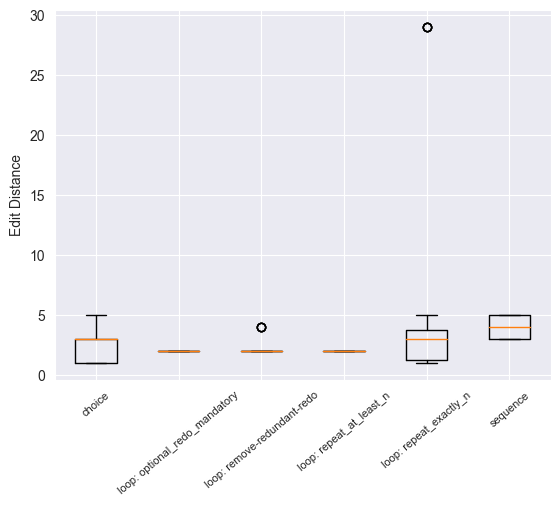

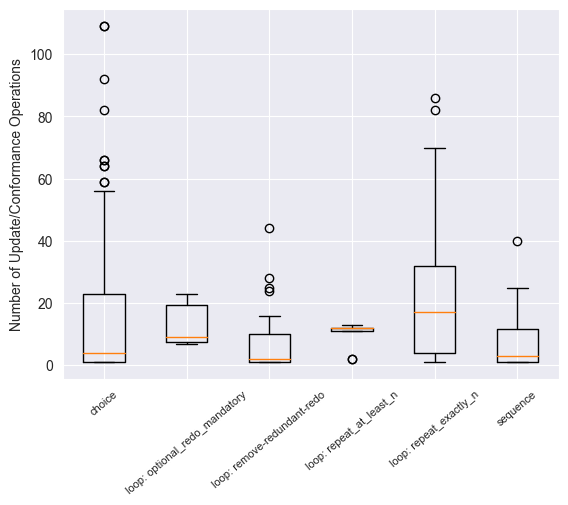

In [11]:
draw_plots_for_all_approaches(
    r'C:\Users\ahmad\OneDrive\Desktop\Sem6\Thesis\experiments\20+shifting_window+10+RequestForPayment+85.0+5+TRUE',
    'RequestForPayment: Shifting window sampling (10) / Varied negative variants / Thresholds: fitness(min): 85, edit-distance(max): 5, threshold stop: TRUE'
)

-------------------------------------------------------------------------------------------------------------------------------------------------------
RequestForPayment: Shifting window sampling (10) / Varied negative variants / Thresholds: fitness(min): 85, edit-distance(max): 5, threshold stop: FALSE
-------------------------------------------------------------------------------------------------------------------------------------------------------


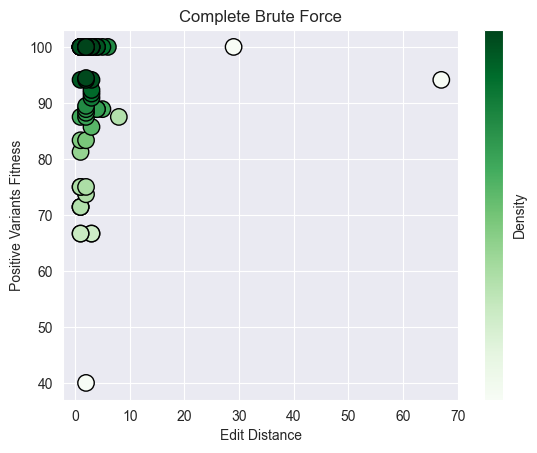

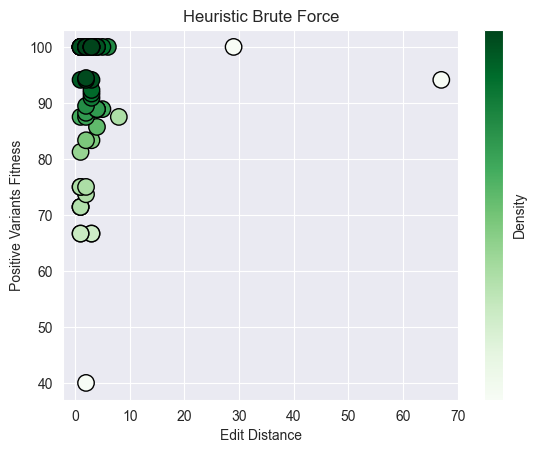

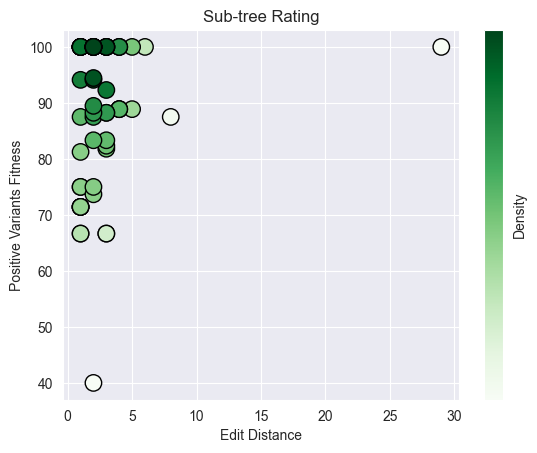

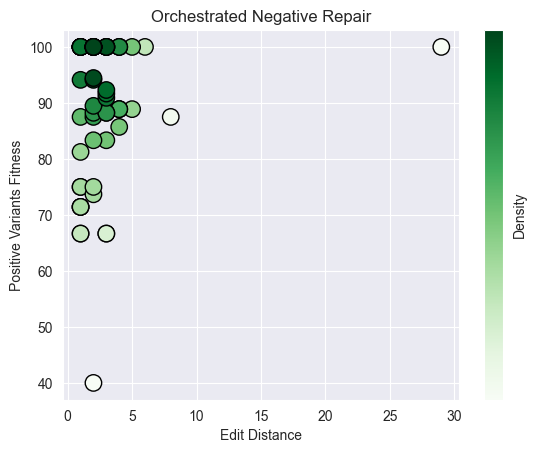

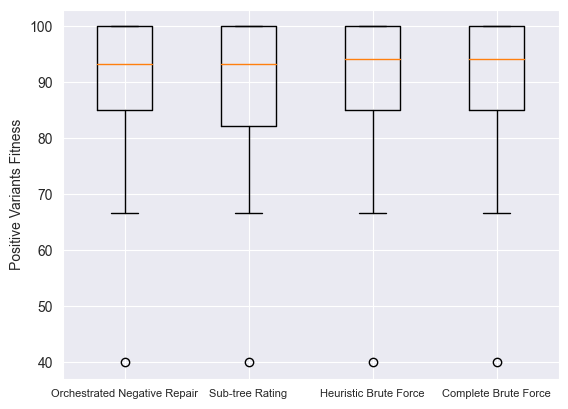

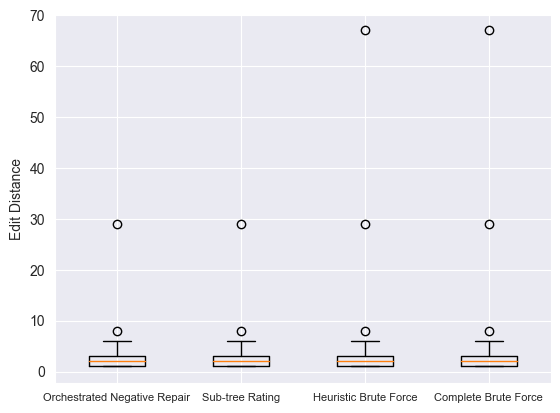

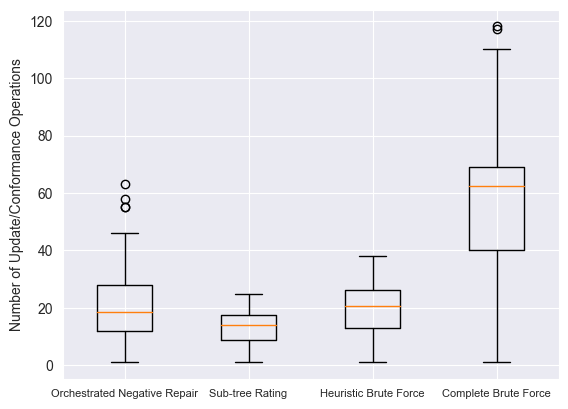

<Figure size 640x480 with 0 Axes>

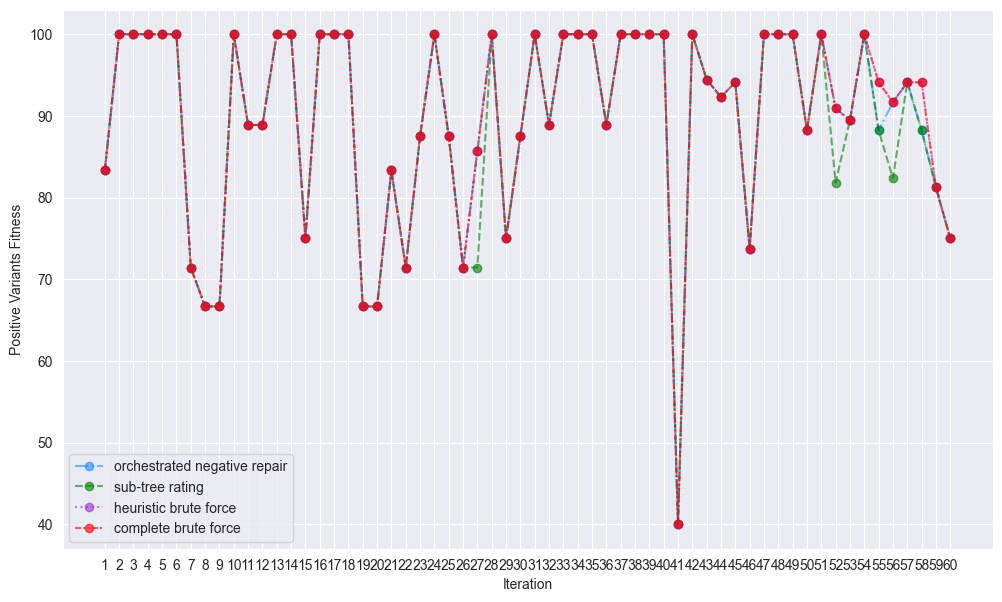

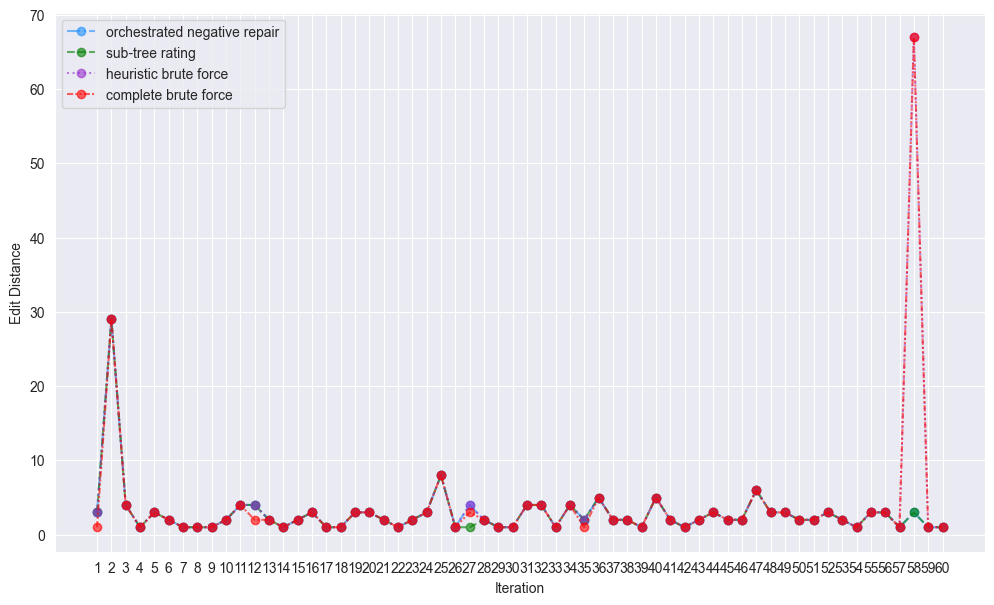

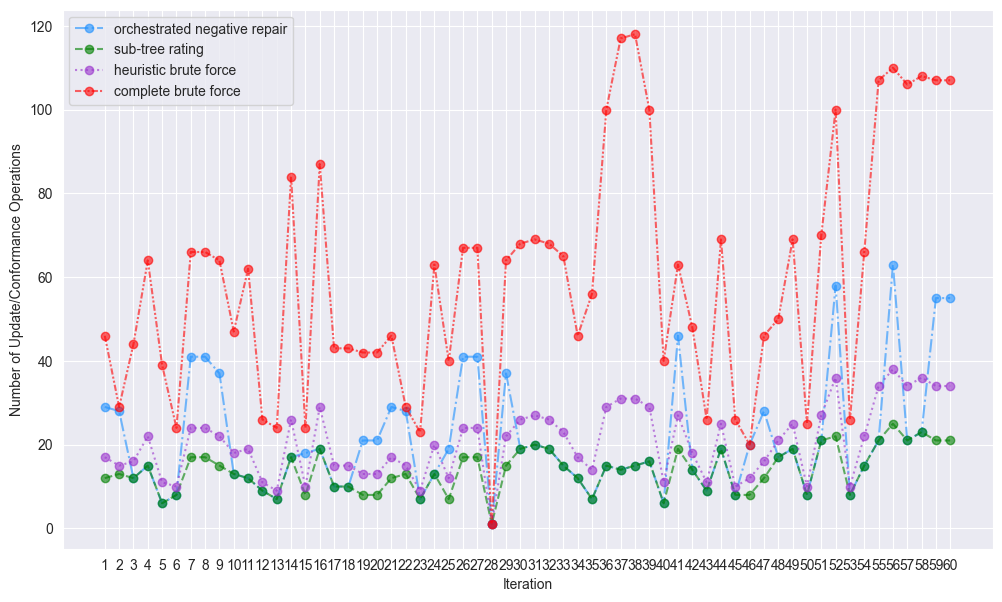

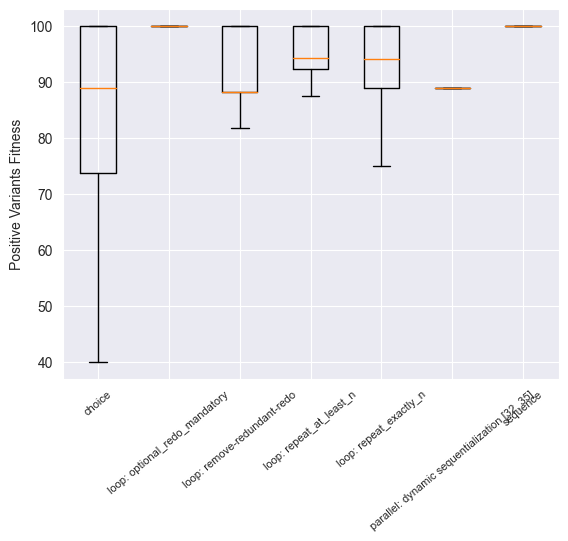

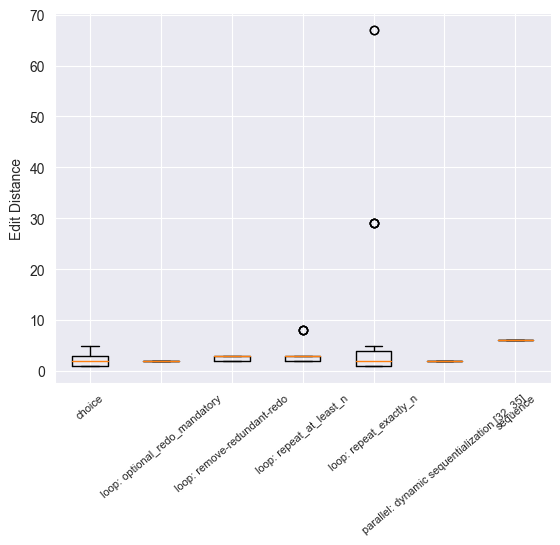

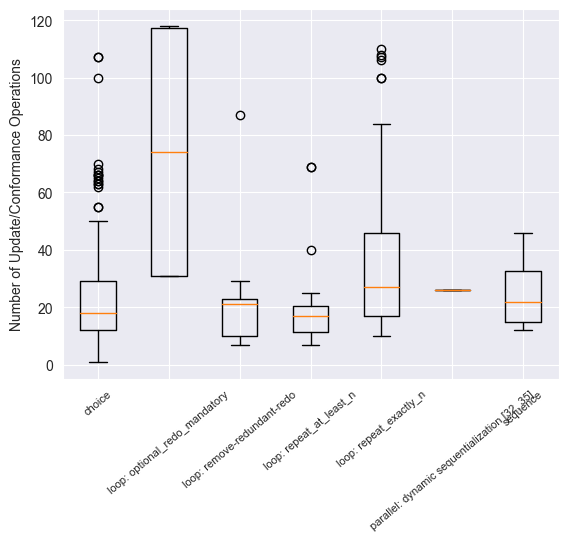

In [12]:
draw_plots_for_all_approaches(
    r'C:\Users\ahmad\OneDrive\Desktop\Sem6\Thesis\experiments\20+shifting_window+10+RequestForPayment+85.0+5+FALSE',
    'RequestForPayment: Shifting window sampling (10) / Varied negative variants / Thresholds: fitness(min): 85, edit-distance(max): 5, threshold stop: FALSE'
)